# Load libraries, configuration

In [ ]:
import os, json
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import read_csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

mpl.rcParams['figure.figsize'] = (25,10)
mpl.rcParams['axes.grid'] = False
np.random.seed(0)

In [ ]:
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [ ]:
user = 'participant10'
interval = '15min'

columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
# columns += ['time_from_last_drug_taken'] #, 'wo_duration']

# Additional data
columns += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos'] # 'timestamp_hour',

# 'wearing_off' | 'wearing_off_post_meds' | 'wearing_off_lead60'
target_column = 'wearing_off' 
columns.append(target_column)

# features to normalize
# timestamp_dayofweek, wearing_off were not normalized
normalize_features = ['heart_rate', 'steps', 'stress_score',
                      'awake', 'deep', 'light', 'rem',
                      'nonrem_total', 'total',
                      'nonrem_percentage', 'sleep_efficiency',
                      'timestamp_hour_sin', 'timestamp_hour_cos']

participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      BalancedSparseCategoricalAccuracy()]

BATCH_SIZE = 8
MAX_EPOCHS = 100
LEARNING_RATE = 1e-3
SHIFT = 4
use_hourly = True

# Load data

In [ ]:
dataset = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter data based on participants' dictionary
dataset = dataset.loc[
    (dataset.index >= participant_dictionary[user]['start_date']) &
    (dataset.index < participant_dictionary[user]['end_date_plus_two'])
]
df = dataset

In [ ]:
neg, pos = np.bincount(df[target_column])
total = neg + pos
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

## Slice to get hourly data

In [ ]:
# Slice [start:stop:step], starting from index 0, take every 4 record
# Take every hour record only
df = dataset[::4].copy() 

# Fix columns arrangement
dataset = dataset.reindex(columns=columns[1:])
record_size_per_day = 24

## Encode hour-feature as cyclical features
* [Encoding Cyclical Features for Deep Learning](https://www.avanwyk.com/encoding-cyclical-features-for-deep-learning/)
* [request: year/quarter/month/week/day sine/cosine for Machine Learning](https://github.com/tidyverse/lubridate/issues/731)
$$
\frac{\text{24 hours}}{\text{1 day}} \cdot \frac{\text{60 minutes}}{\text{1 hour}} \cdot \frac{\text{60 seconds}}{\text{1 minute}} = \frac{\text{86,400 seconds}}{\text{1 day}}
$$

In [ ]:
# Fix timestamp format
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')

# Convert to timestamp
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Get seconds per day
day = 24 * 60 * 60 
# Get seconds per year
year = 365.2425 * day

# Get sine(), cosine() for hour-feature
df['timestamp_hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['timestamp_hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# Move `wearing_off` feature at the end of the dataframe
tmp = df.pop('timestamp_dayofweek')
df['timestamp_dayofweek'] = tmp
tmp = df.pop('wearing_off')
df['wearing_off'] = tmp

display(df.shape)
display(df.head())

## Visualize data with wearing-off periods

In [ ]:
# specify columns to plot
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
i = 1
# plot each column
plt.figure(figsize=(25,10))
for group in plot_cols:
    if group == 'wearing_off':
        continue
    ax = plt.subplot(len(plot_cols), 1, i)
    plt.fill_between(
        plot_features.index, 0, plot_features.loc[:, [group]].max(), where=plot_features.wearing_off, alpha=0.4, color="red", transform=ax.get_xaxis_transform()
    )
    plt.plot(plot_features.loc[:, [group]])
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.suptitle(f'Input features with wearing-off periods for Participant {user.replace("participant", "")}')
plt.savefig(f'./results/{user}_wearing_off.pdf')
plt.show()

# or
# plot_cols = df.columns
# plot_features = df[plot_cols]
# plot_features.index = date_time
# axes = plot_features.plot(subplots=True)
# for axis in axes:
#     axis.fill_between(
#         plot_features.index, 0, 100, where=plot_features.wearing_off, alpha=0.4, color="red", transform=axis.get_xaxis_transform()
#     )

## Summary of data

In [ ]:
if os.path.exists(f'./results/descriptive_summary.xlsx'):
    with pd.ExcelWriter(f'./results/descriptive_summary.xlsx', engine='openpyxl', mode='a') as writer:
        df.describe().transpose().to_excel(writer, sheet_name=f'{user}')
else:
    with pd.ExcelWriter(f'./results/descriptive_summary.xlsx', engine='openpyxl', mode='w') as writer:
        df.describe().transpose().to_excel(writer, sheet_name=f'{user}')

df.describe().transpose()

# Split data
* (60%, 20%, 20%) = training, validation, test sets
* Not randomly shuffled before splitting

In [ ]:
record_size_per_day = 96

# training data 60% 
TRAINING_PERCENTAGE = 0.6
# validation data 20%
VALIDATION_PERCENTAGE = 0.2

column_indices = { name: i for i, name in enumerate(df.columns) }
total_rows = len(df)
num_features = len(df.columns)

training_end_index = int(total_rows * TRAINING_PERCENTAGE)
validation_end_index = int(total_rows * (TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE))

train_df = df[0:training_end_index].copy()
validation_df = df[training_end_index:validation_end_index].copy()
test_df = df[validation_end_index:].copy()

print(f"Training data: {round(len(train_df)/record_size_per_day, 3)} days")
print(f"Validation data: {round(len(validation_df)/record_size_per_day, 3)} days")
print(f"Test data: {round(len(test_df)/record_size_per_day, 3)} days")
print(f"Total data: {round(len(df)/record_size_per_day, 3)} days")

In [ ]:
record_size_per_day = 24

def split_train_validation_test_set(df, test_set_size=1, validation_percentage=0.2):
    test_size = record_size_per_day * test_set_size
    test_set = df.tail(test_size).copy()
    total_rows = len(df) - test_size
    training_end_index = int(total_rows - total_rows * validation_percentage)
    validation_end_index = int(total_rows)    
    
    train_df = df.iloc[0:training_end_index].copy()
    validation_df = df.iloc[training_end_index:validation_end_index].copy()
    return train_df, validation_df, test_set

train_df, validation_df, test_df = split_train_validation_test_set(df, 
                                                                   test_set_size=1, 
                                                                   validation_percentage=0.2)

print(f"Training data: {round(len(train_df)/record_size_per_day * 1, 3)} days")
print(f"Validation data: {round(len(validation_df)/record_size_per_day * 1, 3)} days")
print(f"Test data: {round(len(test_df)/record_size_per_day * 1, 3)} days")
print(f"Total data: {round(len(df)/record_size_per_day * 1, 3)} days")

# Normalize data
$$
Z = \frac{X - \bar{X}}{\sigma}
$$
where:
* $Z$: normalized data
* $X$: input features
* $\bar{X}$: average of each input feature
* $\sigma$: standard deviation of each input feature

Note: Use $\bar{X}_{training}$ & $\sigma_{training}$ so that models have no access to the values in the **validation** & **test** sets

In [ ]:
# features to normalize
# timestamp_dayofweek, wearing_off were not normalized
normalize_features = ['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 'light', 'rem',
 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
 'timestamp_hour_sin', 'timestamp_hour_cos'] 
train_mean = train_df.loc[:, normalize_features].mean()
train_std = train_df.loc[:, normalize_features].std()

train_df.loc[:, normalize_features] = (train_df.loc[:, normalize_features] - train_mean) / train_std
validation_df.loc[:, normalize_features] = (validation_df.loc[:, normalize_features] - train_mean) / train_std
test_df.loc[:, normalize_features] = (test_df.loc[:, normalize_features] - train_mean) / train_std

In [ ]:
df_standardized = (df.loc[:, normalize_features] - train_mean) / train_std
df_standardized = pd.merge(df_standardized, df.iloc[:, -2:], left_index=True,right_index=True)
df_standardized = df_standardized.melt(var_name='Columns', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Columns', y='Normalized', data=df_standardized)
_ = ax.set_xticklabels(df.keys(), rotation=45)
plt.title("Distribution of normalized features")
# plt.savefig(f'./results/{user}_distribution_normalized_data.pdf')
plt.show()

# Data window

## `WindowGenerator` class
`WindowGenerator` class generates data window with the following specifications:
* width / number of timesteps of the input data and label
* offset time between input data & label
* features used for inputs, label or both

| [Source: tensorflow.org](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_1h.png) |
|-----|
| ![raw window.png](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_1h.png) |

* `Input width = 6`: uses 6-hour history
* `Label width = 1`, `offset = 1`: predicts next 1-hour into the future

In [ ]:
BATCH_SIZE = 8
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, validation_df=validation_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.validation_df = validation_df
    self.test_df = test_df

    # Work out the target label column indices.
    # Example: { 'wearing_off': 0 }
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    # input column indices
    # Example: { 'heart_rate': 0 , 'stress_score': 1 }
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## `split_window` function
Converts data into window of inputs and window of labels

| [Source: tensorflow.org](https://www.tensorflow.org/tutorials/structured_data/images/split_window.png) |
|-----|
| ![split_window.png](https://www.tensorflow.org/tutorials/structured_data/images/split_window.png) |

**Note**: Added `remove_target_column_from_input` parameter to control whether target column shall be included in the input
* `True`: if target column/s should not be included
* `False`: if target column/s should be included

In [ ]:
def split_window(self, features, remove_target_column_from_input=True):
    if remove_target_column_from_input:
        inputs = features[:, self.input_slice, :14]
    else:
        inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

## `make_dataset` function
Converts Dataframe into `tf.data.Dataset` of `(input_window, label_window)` using `tf.keras.utils.timeseries_dataset_from_array`.

Each window has dimension of `(number_of_batches, total_window_size, number_of_features)`.

**Note**: Accepts `remove_target_column_from_input` parameter to control whether target column shall be included in the input
* `True`: if target column/s should not be included
* `False`: if target column/s should be included

| Sample batch |
|-----|
| 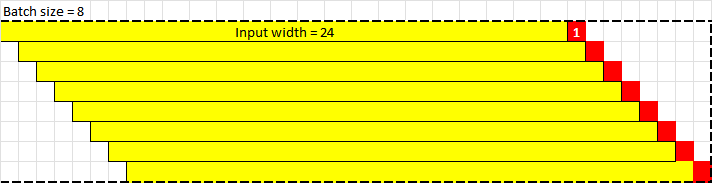 |

In [ ]:
def make_dataset(self, data, remove_target_column_from_input=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=BATCH_SIZE,)
    
    ds = ds.map(lambda d: self.split_window(d, remove_target_column_from_input))
    
    return ds

WindowGenerator.make_dataset = make_dataset

## `train`, `validation`, `test` & `sample` functions

* `train`, `validation`, `test`: holds the train, validation & test sets inside the `WindowGenerator` instance.<br>
By default, each set remove target column from input window.

* `sample`: holds a sample from train set for visualization.<br>
By default, target column is not remove as it is required in the visualization.

In [ ]:
def train(self, remove_target_column_from_input=True):
    return self.make_dataset(self.train_df, remove_target_column_from_input)

def validation(self, remove_target_column_from_input=True):
    return self.make_dataset(
        self.validation_df, 
        remove_target_column_from_input=remove_target_column_from_input)

def test(self, remove_target_column_from_input=True):
    return self.make_dataset(
        self.test_df, 
        remove_target_column_from_input=remove_target_column_from_input)

def sample(self):
    result = self.make_dataset(self.train_df, remove_target_column_from_input=False)
    result = next(iter(result))
    return result

WindowGenerator.train = train
WindowGenerator.validation = validation
WindowGenerator.test = test
WindowGenerator.sample = sample

## `plot` function
Generate a maximum of 3 subplots from the sample set.<br>
The plot shows the input data, ground truth data, and predicted data (if model is provided).

**Note**: Accepts `override` parameter when model expects data window to have target column.<br>
Otherwise, it expects data window without target column

In [ ]:
def plot(self, model=None, plot_col='wearing_off', max_subplots=3, override=False):
    inputs, labels = self.sample()
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index
        if label_col_index is None:
          continue
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            if override or inputs.shape[2] == 14:
                predictions = model(inputs)
            else:
                predictions = model(inputs[:, :, :14])
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
          plt.legend()
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## `WindowGenerator` usage
**Example**: Predict **1** hour into the future, given **24** hours of history.

In [ ]:
BATCH_SIZE = 8
w1 = WindowGenerator(input_width=24, label_width=1, shift=1,
                     train_df=train_df, validation_df=validation_df, test_df=test_df,
                     label_columns=['wearing_off'])
w1.plot(plot_col="wearing_off")

for example_inputs, example_labels in w1.train().take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

# Experiments

|Single-step window |Expanded single-step window|Conv window |
|-------------------|---------------------------|------------|
|![single-step-window.png](https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png)|![expanded-single-step-window.png](https://www.tensorflow.org/tutorials/structured_data/images/last_window.png)       |![conv.png](https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png) |

In [ ]:
SHIFT = 4
BATCH_SIZE = 8
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=SHIFT,
                                     train_df=train_df, validation_df=validation_df, test_df=test_df,
                                     label_columns=['wearing_off'])
single_step_window

In [ ]:
wide_single_step_window = WindowGenerator(input_width=24, label_width=24, shift=SHIFT,
                              train_df=train_df, validation_df=validation_df, test_df=test_df,
                              label_columns=['wearing_off'])
wide_single_step_window

In [ ]:
MULTI_STEP_WIDTH = 24 # t0, t1, t2, ..., t24
multi_step_window = WindowGenerator(input_width=MULTI_STEP_WIDTH, label_width=1, shift=SHIFT,
                                    train_df=train_df, validation_df=validation_df, test_df=test_df,
                                    label_columns=['wearing_off'])
multi_step_window

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (MULTI_STEP_WIDTH - 1)
wide_multi_step_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                                         train_df=train_df, validation_df=validation_df, test_df=test_df,
                                         label_columns=['wearing_off'])

wide_multi_step_window

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)

  history = model.fit(window.train(True), epochs=MAX_EPOCHS,
                      validation_data=window.validation(True),
                      callbacks=[early_stopping])
  return history

In [ ]:
validation_performance = {}
test_performance = {}

## Baseline model

In [ ]:
model_name = 'Baseline'

K.clear_session()
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

### Train model

In [ ]:
baseline = Baseline(label_index=column_indices['wearing_off'])
baseline.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=METRICS)

In [ ]:
validation_performance[model_name] = baseline.evaluate(single_step_window.validation(False))
test_performance[model_name] = baseline.evaluate(single_step_window.test(False), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
wide_single_step_window.plot(baseline, override=True)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in single_step_window.test(False):
    output = baseline(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))

In [ ]:
# if os.path.exists(f'./results/confusion_matrix.xlsx'):
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
# else:
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='w') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
    
print(
    classification_report(predictions, labels,
                      target_names=['normal', 'wearing-off'],
                      output_dict=False)
)

In [ ]:
cm = confusion_matrix(predictions, labels, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
disp.plot()
plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
plt.show()

## Linear model

In [ ]:
model_name = "Linear"

K.clear_session()
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

### Train model

In [ ]:
history = compile_and_fit(linear, single_step_window)

In [ ]:
validation_performance[model_name] = linear.evaluate(single_step_window.validation())
test_performance[model_name] = linear.evaluate(single_step_window.test(), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
wide_single_step_window.plot(linear)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')

### Visualize learning curve

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in single_step_window.test():
    output = linear(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
    
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [ ]:
# if os.path.exists(f'./results/confusion_matrix.xlsx'):
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
# else:
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='w') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')

print(
    classification_report(predictions, labels,
                          target_names=['normal', 'wearing-off'],
                          output_dict=False)
)

In [ ]:
cm = confusion_matrix(predictions, labels, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
disp.plot()
plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
plt.show()

### Feature importance from layer's weights


In [ ]:
plt.bar(x = range(len(train_df.columns) - 1),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns) - 1))
_ = axis.set_xticklabels(train_df.columns[:-1], 
                         rotation=45, fontsize=18, ha='right')
plt.title(f'Feature importance for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_feature_importance_{model_name}.pdf')
plt.show()

## Single-time-step Dense Model

In [ ]:
model_name = "Single-time-step Dense"

K.clear_session()
single_time_step_dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

### Train model

In [ ]:
history = compile_and_fit(single_time_step_dense, single_step_window)

In [ ]:
validation_performance[model_name] = single_time_step_dense.evaluate(single_step_window.validation())
test_performance[model_name] = single_time_step_dense.evaluate(single_step_window.test(), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
wide_single_step_window.plot(single_time_step_dense)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')

### Visualize learning curve

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in single_step_window.test():
    output = single_time_step_dense(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
    
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [ ]:
# if os.path.exists(f'./results/confusion_matrix.xlsx'):
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
# else:
#     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='w') as writer:
#         pd.DataFrame(
#             classification_report(predictions, labels,
#                                   target_names=['normal', 'wearing-off'],
#                                   output_dict=True)
#         ).to_excel(writer, sheet_name=f'{user} - {model_name}')

print(
    classification_report(predictions, labels,
                          target_names=['normal', 'wearing-off'],
                          output_dict=False)
)

In [ ]:
cm = confusion_matrix(predictions, labels, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
disp.plot()
plt.suptitle(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
plt.show()

### Feature importance from layer's weights


In [ ]:
plt.bar(x = range(len(train_df.columns) - 1),
        height=single_time_step_dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns) - 1))
_ = axis.set_xticklabels(train_df.columns[:-1], 
                         rotation=45, fontsize=18, ha='right')
plt.title(f'Feature importance for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_feature_importance_{model_name}.pdf')
plt.show()

## Multi-time-step Dense Model

In [ ]:
model_name = "Multi-time-step Dense"

K.clear_session()
multi_time_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

### Train model

In [ ]:
history = compile_and_fit(multi_time_step_dense, multi_step_window)

In [ ]:
validation_performance[model_name] = multi_time_step_dense.evaluate(multi_step_window.validation())
test_performance[model_name] = multi_time_step_dense.evaluate(multi_step_window.test(), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
multi_step_window.plot(multi_time_step_dense)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')

### Visualize learning curve

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in multi_step_window.test():
    output = multi_time_step_dense(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
    
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [ ]:
if 1.0 in labels:
    # if os.path.exists(f'./results/confusion_matrix.xlsx'):
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
    # else:
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='w') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')

    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )
else:
    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )

In [ ]:
if 1.0 in labels:
    cm = confusion_matrix(predictions, labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
    # plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
    plt.show()
else:
    cm = confusion_matrix(predictions, labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
    # plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
    plt.show()

### Feature importance from layer's weights


In [ ]:
multi_time_step_dense.summary()

In [ ]:
# plt.bar(x = range(len(train_df.columns) - 1),
#         height=multi_time_step_dense.layers[3].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns) - 1))
# _ = axis.set_xticklabels(train_df.columns[:-1], 
#                          rotation=45, fontsize=18, ha='right')
# plt.title(f'Feature importance for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_feature_importance_{model_name}.pdf')
# plt.show()

## CNN model

In [ ]:
model_name = "CNN"

K.clear_session()
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(MULTI_STEP_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

### Train model

In [ ]:
history = compile_and_fit(cnn_model, multi_step_window)

In [ ]:
validation_performance['CNN'] = cnn_model.evaluate(multi_step_window.validation())
test_performance['CNN'] = cnn_model.evaluate(multi_step_window.test(), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
wide_multi_step_window.plot(cnn_model)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')
plt.show()

### Visualize learning curve

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in multi_step_window.test():
    output = cnn_model(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
    
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [ ]:
if 1.0 in labels:
    # if os.path.exists(f'./results/confusion_matrix.xlsx'):
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
    # else:
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='w') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')

    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )
else:
    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )

In [ ]:
if 1.0 in labels:
    cm = confusion_matrix(predictions, labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
    # plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
    plt.show()
else:
    cm = confusion_matrix(predictions, labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
    # plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
    plt.show()

## RNN model

In [ ]:
model_name = 'LSTM'
K.clear_session()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

### Train model

In [ ]:
history = compile_and_fit(lstm_model, wide_single_step_window)

In [ ]:
validation_performance[model_name] = lstm_model.evaluate(wide_single_step_window.validation())
test_performance[model_name] = lstm_model.evaluate(wide_single_step_window.test(), verbose=0)

In [ ]:
validation_performance

In [ ]:
test_performance

### Visualize results

In [ ]:
wide_single_step_window.plot(lstm_model)
plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model_name}')
# plt.savefig(f'./results/{user}_sample_prediction_{model_name}.pdf')
plt.show()

### Visualize learning curve

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model_name}')
plt.legend()
# plt.savefig(f'./results/{user}_learning_curve_{model_name}.pdf')
plt.show()

### Confusion matrix

In [ ]:
predictions = []
labels = []
for input, label in single_step_window.test():
    output = lstm_model(input).numpy()
    predictions += list(output.reshape(len(output)))
    
    l = label.numpy()
    labels += list(l.reshape(len(l)))
    
predictions = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [ ]:
if 1.0 in labels:
    # if os.path.exists(f'./results/confusion_matrix.xlsx'):
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')
    # else:
    #     with pd.ExcelWriter(f'./results/confusion_matrix.xlsx', engine='openpyxl', mode='a') as writer:
    #         pd.DataFrame(
    #             classification_report(predictions, labels,
    #                                   target_names=['normal', 'wearing-off'],
    #                                   output_dict=True)
    #         ).to_excel(writer, sheet_name=f'{user} - {model_name}')

    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )
else:
    print(
        classification_report(predictions, labels,
                              target_names=['normal', 'wearing-off'],
                              output_dict=False)
    )

In [ ]:
if 1.0 in labels:
    cm = confusion_matrix(predictions, labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'wearing-off'])
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model_name}')
    # plt.savefig(f'./results/{user}_confusion_matrix_{model_name}.pdf')
    plt.show()

## Performance

In [ ]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'auc' # accuracy
metric_index = lstm_model.metrics_names.index(metric_name)
validation_accuracy = [v[metric_index] for v in validation_performance.values()]
test_accuracy = [v[metric_index] for v in test_performance.values()]

plt.ylabel('accuracy [wearing_off, normalized]')
plt.bar(x - 0.17, validation_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test')
plt.xticks(ticks=x, labels=test_performance.keys(),
           rotation=45)
_ = plt.legend()
plt.title(f'Test Performance for Participant {user.replace("participant", "")} on varying models')
# plt.savefig(f'./results/{user}_test_performance_{model_name}.pdf')
plt.show()

In [ ]:
display(
  pd.DataFrame(validation_performance,
              index = ['loss'] + list(map(lambda m: m.name, METRICS))
              )
)

display(
  pd.DataFrame(test_performance,
              index = ['loss'] + list(map(lambda m: m.name, METRICS))
              )
)

In [ ]:
val_perf = pd.DataFrame(validation_performance).transpose().rename(columns={0: 'val_loss', 1: 'val_accuracy'})
val_perf

In [ ]:
test_perf = pd.DataFrame(test_performance).transpose().rename(columns={0: 'loss', 1: 'accuracy'})
test_perf

In [ ]:
final_performance = pd.concat([val_perf, test_perf], axis=1, join='inner')
if os.path.exists(f'./results/final_performance.xlsx'):
    with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='a') as writer:
        final_performance.to_excel(writer, sheet_name=f'{user}')
else:
    with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='w') as writer:
        final_performance.to_excel(writer, sheet_name=f'{user}')

# Feature Importance

In [ ]:
import shap

In [ ]:
for test_input, test_label in multi_step_window.test().take(100):
    print(test_input.shape)
    print(test_label.shape)

In [ ]:
test_input.numpy()

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
test_input.reshape([8*24, 14]).numpy().append( pd.DataFrame(test_input.reshape([8*24, 14]).numpy()) )

In [ ]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(cnn_model, train_X[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_X[:10])

In [ ]:
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0].reshape(10,1440), reframed.loc[:, reframed.columns != target_column].columns)